# Predecessor follower model predictive control study with noise

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.sparse_quad_pfmpc import SparseQuadPFMPC

In [3]:
rng = np.random.default_rng()

### Platoon parameters

In [4]:
H = 200   # planning horizon
N = 10    # number of vehicles in platoon, including leader
dt = 0.1  # timestep
total_time = 25.0  # seconds
total_time += dt * H
d_des = 5   # desired spacing
da_max = 2  # max jerk

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
taus = [None] + [dt + (1 - dt) * (n-1) / N for n in range(1, N+1)]
# taus = [None] + [0.1 for _ in range(N)]
print(taus)
dyns = [None] + [LinearLong(dt, x_min, x_max, u_min, u_max, tau) for tau in taus[1:]]
n, m, p = dyns[1].n, dyns[1].m, dyns[1].p

# algorithm
q_vals = [None] + [1 for _ in range(N)]
q_p_vals = [None, 1] + [1 for _ in range(1, N)]
r_vals = [None] + [.1 for _ in range(N)]
Q = [None] + [q * np.eye(p) for q in q_vals[1:]]
Q_p = [None] + [q_p * np.eye(p) for q_p in q_p_vals[1:]]
R = [None] + [r * np.eye(m) for r in r_vals[1:]]
pfmpc = [None] + [SparseQuadPFMPC(Q[i], Q_p[i], R[i], dyns[i], u_min, u_max, H, da_max) 
                  for i in range(1, N+1)]

# observer params
W = 0.001 * np.eye(n)  # process noise covariance
V = 0.001 * np.eye(p)  # sensor noise covariance
S = [None] + [sp.linalg.solve_discrete_are(dyns[i].Ad.T, dyns[i].C.T, W, V) 
              for i in range(1, N+1)]
L = [None] + [-dyns[i].Ad @ S[i] @ dyns[i].C.T @ np.linalg.inv(dyns[i].C @ S[i] @ dyns[i].C.T + V) 
              for i in range(1, N+1)]

[None, 0.1, 0.19, 0.28, 0.37, 0.45999999999999996, 0.55, 0.64, 0.73, 0.82, 0.9099999999999999]


### Reference trajectory - Acceleration

In [6]:
dist_start = 1.0
dist_end = 6.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, 
                              v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

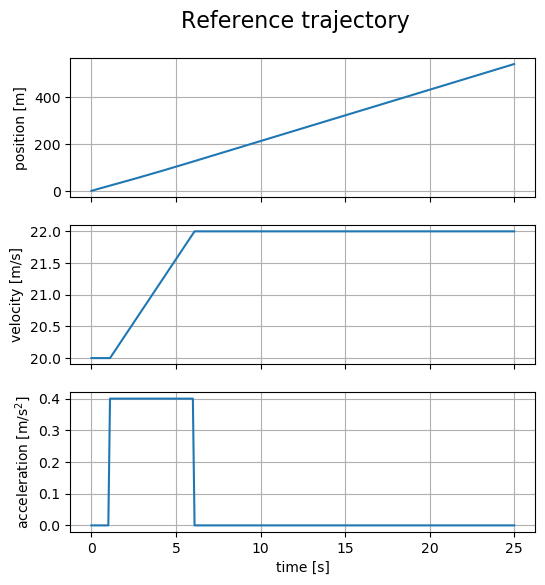

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

### Leader reference tracking

In [8]:
x_track = np.zeros((n, T-H))
x_track_hat = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

# initial condition
x_track[:, 0] = x_ref[:, 0] + rng.multivariate_normal(np.zeros(n), W)
x_track_hat[:, 0] = x_track[:, 0] + rng.multivariate_normal(np.zeros(n), W)

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((n, H + 1))
y_a_track = np.zeros((p, H + 1))
u_a_track = np.zeros((m, H))
x_a_track[:, 0] = x_track_hat[:, 0]
y_a_track[:, 0] = dyns[1].sense(x_a_track[:, 0])
for k in range(H):
    x_a_track[:, k+1] = dyns[1].forward(x_a_track[:, k], u_a_track[:, k])
    y_a_track[:, k+1] = dyns[1].sense(x_a_track[:, k+1])

In [9]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    y_a = copy.deepcopy(y_a_track)
    y_pred_a = y_ref[:, k:k+H+1]
    d = 0.

    z_opt, prob = pfmpc[1].control(x_0, y_a, y_pred_a, d)
    if prob.status != 'optimal':
        print(f"timestep {k}, problem returned: {prob.status}")
        break

    x_opt = np.zeros((n, H+1))
    u_opt = np.zeros((m, H))
    y_opt = np.zeros((p, H+1))

    x_opt[:, 0] = x_0
    u_opt[:, 0] = z_opt[:m]
    y_opt[:, 0] = z_opt[m:m+p]
    print("out of class", x_0[-1], da_max*dt + x_0[-1], x_0[-1] - da_max*dt)
    for t, i in enumerate(range(m+p, len(z_opt), n+m+3*p)):
        x_opt[:, t+1] = z_opt[i:i+n]
        u_opt[:, t+1] = z_opt[i+n:i+n+m]
        y_opt[:, t+1] = z_opt[i+n+m:i+n+m+p]
    x_opt[:, H] = dyns[1].forward(x_opt[:, H-1], u_opt[:, H-1])
    y_opt[:, H] = dyns[1].sense(x_opt[:, H])

    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyns[1].forward(x_0, u_opt[:, 0]) + rng.multivariate_normal(np.zeros(n), W)
    y = dyns[1].C @ x_track[:, k] + rng.multivariate_normal(np.zeros(p), V)
    x_track_hat[:, k+1] = (dyns[1].Ad + L[1] @ dyns[1].C) @ x_track_hat[:, k] + \
        dyns[1].Bd @ u_track[:, k] - L[1] @ y

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = np.zeros((m))
    x_a_track[:, 0] = x_track_hat[:, k+1]
    y_a_track[:, 0] = dyns[1].sense(x_a_track[:, 0])
    for t in range(H):
        x_a_track[:, t+1] = dyns[1].forward(x_a_track[:, t], u_a_track[:, t])
        y_a_track[:, t+1] = dyns[1].sense(x_a_track[:, t+1])
    
end_time = time.time()
avg_time = (end_time - start_time) / (T - H)
print(f"pf mpc leader track avg rate: {1 / avg_time} Hz")
print("\nproblem data:")
print(f"    scalar variables: {prob.size_metrics.num_scalar_variables}")
print(f"    scalar eq constraints: {prob.size_metrics.num_scalar_eq_constr}")
print(f"    scalar ineq constraints: {prob.size_metrics.num_scalar_leq_constr}")

  0%|          | 0/250 [00:00<?, ?it/s]

  4%|▎         | 9/250 [00:00<00:02, 84.55it/s]

in class 0.05002752647574015 0.25002752647574017 0.14997247352425985
out of class 0.05002752647574015 0.25002752647574017 -0.14997247352425985
in class 0.11872182465535067 0.3187218246553507 0.08127817534464934
out of class 0.11872182465535067 0.3187218246553507 -0.08127817534464934
in class 0.07768991834769391 0.2776899183476939 0.1223100816523061
out of class 0.07768991834769391 0.2776899183476939 -0.1223100816523061
in class 0.15162518688626545 0.35162518688626543 0.048374813113734566
out of class 0.15162518688626545 0.35162518688626543 -0.048374813113734566
in class 0.08047696138755743 0.28047696138755746 0.11952303861244258
out of class 0.08047696138755743 0.28047696138755746 -0.11952303861244258
in class 0.11414446265357792 0.3141444626535779 0.0858555373464221
out of class 0.11414446265357792 0.3141444626535779 -0.0858555373464221
in class 0.0947968802475901 0.2947968802475901 0.10520311975240991
out of class 0.0947968802475901 0.2947968802475901 -0.10520311975240991
in class 0.

 12%|█▏        | 30/250 [00:00<00:02, 94.25it/s]

out of class 0.1336621748963886 0.3336621748963886 -0.06633782510361141
in class 0.0635050111656476 0.2635050111656476 0.1364949888343524
out of class 0.0635050111656476 0.2635050111656476 -0.1364949888343524
in class 0.11898470845161552 0.31898470845161553 0.0810152915483845
out of class 0.11898470845161552 0.31898470845161553 -0.0810152915483845
in class 0.06817667224769798 0.268176672247698 0.13182332775230204
out of class 0.06817667224769798 0.268176672247698 -0.13182332775230204
in class 0.17803543321462026 0.3780354332146203 0.021964566785379752
out of class 0.17803543321462026 0.3780354332146203 -0.021964566785379752
in class 0.06617044055164821 0.26617044055164824 0.1338295594483518
out of class 0.06617044055164821 0.26617044055164824 -0.1338295594483518
in class 0.150227188675923 0.350227188675923 0.049772811324077015
out of class 0.150227188675923 0.350227188675923 -0.049772811324077015
in class 0.015209454765757989 0.215209454765758 0.18479054523424202
out of class 0.0152094

 20%|█▉        | 49/250 [00:00<00:02, 83.51it/s]

out of class 0.06418923156586231 0.2641892315658623 -0.1358107684341377
in class 0.16229139747075033 0.36229139747075034 0.03770860252924968
out of class 0.16229139747075033 0.36229139747075034 -0.03770860252924968
in class -0.018419859018627256 0.18158014098137276 0.21841985901862726
out of class -0.018419859018627256 0.18158014098137276 -0.21841985901862726
in class 0.16844970704458018 0.3684497070445802 0.031550292955419834
out of class 0.16844970704458018 0.3684497070445802 -0.031550292955419834
in class 0.03085473491151448 0.23085473491151448 0.16914526508848554
out of class 0.03085473491151448 0.23085473491151448 -0.16914526508848554
in class 0.14869611457541468 0.3486961145754147 0.05130388542458533
out of class 0.14869611457541468 0.3486961145754147 -0.05130388542458533
in class 0.042139575494709945 0.24213957549470996 0.15786042450529006
out of class 0.042139575494709945 0.24213957549470996 -0.15786042450529006
in class 0.17292826874846096 0.37292826874846097 0.027071731251539

 26%|██▋       | 66/250 [00:00<00:02, 73.35it/s]

out of class 0.1395483918660426 0.3395483918660426 -0.06045160813395742
in class 0.11369299346107961 0.3136929934610796 0.0863070065389204
out of class 0.11369299346107961 0.3136929934610796 -0.0863070065389204
in class 0.0568842177766764 0.2568842177766764 0.1431157822233236
out of class 0.0568842177766764 0.2568842177766764 -0.1431157822233236
in class 0.10489682320830418 0.3048968232083042 0.09510317679169583
out of class 0.10489682320830418 0.3048968232083042 -0.09510317679169583
in class 0.11574630089300011 0.31574630089300015 0.0842536991069999
out of class 0.11574630089300011 0.31574630089300015 -0.0842536991069999
in class 0.10214089514973093 0.30214089514973097 0.09785910485026908
out of class 0.10214089514973093 0.30214089514973097 -0.09785910485026908
in class 0.11733548210135594 0.317335482101356 0.08266451789864407
out of class 0.11733548210135594 0.317335482101356 -0.08266451789864407
in class 0.10773476084128698 0.307734760841287 0.09226523915871303
out of class 0.107734

 30%|██▉       | 74/250 [00:00<00:02, 68.66it/s]

in class 0.012961197285571643 0.21296119728557167 0.18703880271442835
out of class 0.012961197285571643 0.21296119728557167 -0.18703880271442835
in class 0.16263594508405338 0.3626359450840534 0.03736405491594663
out of class 0.16263594508405338 0.3626359450840534 -0.03736405491594663
in class 0.0213380623146318 0.22133806231463182 0.1786619376853682
out of class 0.0213380623146318 0.22133806231463182 -0.1786619376853682
in class 0.17988138785053037 0.3798813878505304 0.02011861214946964
out of class 0.17988138785053037 0.3798813878505304 -0.02011861214946964
in class 0.06407060054047076 0.26407060054047077 0.13592939945952925
out of class 0.06407060054047076 0.26407060054047077 -0.13592939945952925
in class 0.13365071588976984 0.33365071588976986 0.06634928411023017
out of class 0.13365071588976984 0.33365071588976986 -0.06634928411023017
in class 0.07031961488840864 0.27031961488840867 0.12968038511159136
out of class 0.07031961488840864 0.27031961488840867 -0.12968038511159136
in cl

 35%|███▌      | 88/250 [00:01<00:02, 61.50it/s]

in class 0.15953954397066422 0.35953954397066423 0.04046045602933579
out of class 0.15953954397066422 0.35953954397066423 -0.04046045602933579
in class 0.041201031064969716 0.24120103106496973 0.1587989689350303
out of class 0.041201031064969716 0.24120103106496973 -0.1587989689350303
in class 0.1712581886212145 0.3712581886212145 0.02874181137878551
out of class 0.1712581886212145 0.3712581886212145 -0.02874181137878551
in class 0.02255708603985264 0.22255708603985264 0.17744291396014739
out of class 0.02255708603985264 0.22255708603985264 -0.17744291396014739
in class 0.2137373611439067 0.4137373611439067 -0.013737361143906696
out of class 0.2137373611439067 0.4137373611439067 0.013737361143906696
in class 0.02278442979661282 0.22278442979661284 0.17721557020338718
out of class 0.02278442979661282 0.22278442979661284 -0.17721557020338718
in class 0.20081996681417139 0.4008199668141714 -0.0008199668141713745
out of class 0.20081996681417139 0.4008199668141714 0.0008199668141713745
in 

 38%|███▊      | 95/250 [00:01<00:02, 59.16it/s]

in class 0.0004122927157107978 0.20041229271571082 0.1995877072842892
out of class 0.0004122927157107978 0.20041229271571082 -0.1995877072842892
in class 0.22888327922039842 0.42888327922039843 -0.028883279220398406
out of class 0.22888327922039842 0.42888327922039843 0.028883279220398406
in class -0.01380993990828845 0.18619006009171157 0.21380993990828845
out of class -0.01380993990828845 0.18619006009171157 -0.21380993990828845
in class 0.14907467921560869 0.3490746792156087 0.050925320784391326
out of class 0.14907467921560869 0.3490746792156087 -0.050925320784391326
in class 0.02527621794802628 0.2252762179480263 0.17472378205197373
out of class 0.02527621794802628 0.2252762179480263 -0.17472378205197373
in class 0.17885437263670564 0.3788543726367056 0.021145627363294367
out of class 0.17885437263670564 0.3788543726367056 -0.021145627363294367
in class 0.0054374380755700565 0.20543743807557008 0.19456256192442994
out of class 0.0054374380755700565 0.20543743807557008 -0.194562561

 43%|████▎     | 107/250 [00:01<00:02, 55.91it/s]

out of class 0.1240019041194079 0.3240019041194079 -0.07599809588059211
in class 0.05013954152792006 0.25013954152792006 0.14986045847207996
out of class 0.05013954152792006 0.25013954152792006 -0.14986045847207996
in class 0.17603878884877375 0.37603878884877373 0.023961211151226264
out of class 0.17603878884877375 0.37603878884877373 -0.023961211151226264
in class 0.07687242565718941 0.2768724256571894 0.1231275743428106
out of class 0.07687242565718941 0.2768724256571894 -0.1231275743428106
in class 0.17780245666478386 0.37780245666478385 0.022197543335216147
out of class 0.17780245666478386 0.37780245666478385 -0.022197543335216147
in class 0.00854713137926446 0.20854713137926448 0.19145286862073554
out of class 0.00854713137926446 0.20854713137926448 -0.19145286862073554
in class 0.2472564952067096 0.4472564952067096 -0.047256495206709576
out of class 0.2472564952067096 0.4472564952067096 0.047256495206709576
in class 0.021243934397625897 0.2212439343976259 0.17875606560237411
out

 48%|████▊     | 119/250 [00:01<00:02, 52.00it/s]

out of class 0.04631468185918077 0.2463146818591808 -0.15368531814081923
in class 0.1747083789532111 0.3747083789532111 0.02529162104678892
out of class 0.1747083789532111 0.3747083789532111 -0.02529162104678892
in class 0.06963332039927858 0.26963332039927856 0.13036667960072143
out of class 0.06963332039927858 0.26963332039927856 -0.13036667960072143
in class 0.1154505819727715 0.31545058197277154 0.08454941802722851
out of class 0.1154505819727715 0.31545058197277154 -0.08454941802722851
in class 0.10862413747604278 0.3086241374760428 0.09137586252395723
out of class 0.10862413747604278 0.3086241374760428 -0.09137586252395723
in class 0.0843706221595542 0.2843706221595542 0.11562937784044582
out of class 0.0843706221595542 0.2843706221595542 -0.11562937784044582
in class 0.11925787837251815 0.3192578783725182 0.08074212162748186
out of class 0.11925787837251815 0.3192578783725182 -0.08074212162748186
in class 0.09176837477474346 0.2917683747747435 0.10823162522525655
out of class 0.

 52%|█████▏    | 130/250 [00:02<00:02, 48.66it/s]

out of class 0.1771602565841116 0.3771602565841116 -0.022839743415888403
in class 0.07952419053251303 0.27952419053251304 0.12047580946748698
out of class 0.07952419053251303 0.27952419053251304 -0.12047580946748698
in class 0.1220310581625569 0.3220310581625569 0.07796894183744311
out of class 0.1220310581625569 0.3220310581625569 -0.07796894183744311
in class 0.08021195261005659 0.2802119526100566 0.11978804738994342
out of class 0.08021195261005659 0.2802119526100566 -0.11978804738994342
in class 0.10958795764283798 0.309587957642838 0.09041204235716203
out of class 0.10958795764283798 0.309587957642838 -0.09041204235716203
in class 0.08174625605713458 0.2817462560571346 0.11825374394286543
out of class 0.08174625605713458 0.2817462560571346 -0.11825374394286543
in class 0.0979944010341853 0.2979944010341853 0.10200559896581471
out of class 0.0979944010341853 0.2979944010341853 -0.10200559896581471
in class 0.12940381891982036 0.3294038189198204 0.07059618108017965
out of class 0.12

 54%|█████▍    | 135/250 [00:02<00:02, 46.67it/s]

in class 0.03516438116083232 0.23516438116083233 0.1648356188391677
out of class 0.03516438116083232 0.23516438116083233 -0.1648356188391677
in class 0.1401746706255694 0.3401746706255694 0.05982532937443061
out of class 0.1401746706255694 0.3401746706255694 -0.05982532937443061
in class 0.03290365773315214 0.23290365773315214 0.16709634226684789
out of class 0.03290365773315214 0.23290365773315214 -0.16709634226684789
in class 0.19892689802864985 0.3989268980286499 0.00107310197135016
out of class 0.19892689802864985 0.3989268980286499 -0.00107310197135016
in class -0.003625107488537037 0.19637489251146298 0.20362510748853704
out of class -0.003625107488537037 0.19637489251146298 -0.20362510748853704
in class 0.17987312886955065 0.37987312886955066 0.020126871130449364
out of class 0.17987312886955065 0.37987312886955066 -0.020126871130449364
in class 0.03590205478135995 0.23590205478135995 0.16409794521864007
out of class 0.03590205478135995 0.23590205478135995 -0.16409794521864007
i

 58%|█████▊    | 145/250 [00:02<00:02, 45.39it/s]

out of class -0.038939372353393474 0.16106062764660653 -0.2389393723533935
in class 0.18108520445524023 0.38108520445524025 0.018914795544759777
out of class 0.18108520445524023 0.38108520445524025 -0.018914795544759777
in class 0.034271923018716004 0.23427192301871602 0.165728076981284
out of class 0.034271923018716004 0.23427192301871602 -0.165728076981284
in class 0.12537811162202134 0.32537811162202135 0.07462188837797867
out of class 0.12537811162202134 0.32537811162202135 -0.07462188837797867
in class 0.10188629109032728 0.3018862910903273 0.09811370890967273
out of class 0.10188629109032728 0.3018862910903273 -0.09811370890967273
in class 0.12395916523553362 0.32395916523553364 0.0760408347644664
out of class 0.12395916523553362 0.32395916523553364 -0.0760408347644664
in class 0.09551745501551448 0.2955174550155145 0.10448254498448553
out of class 0.09551745501551448 0.2955174550155145 -0.10448254498448553
in class 0.06200161748673479 0.2620016174867348 0.1379983825132652
out of

 62%|██████▏   | 155/250 [00:02<00:02, 43.79it/s]

out of class 0.08539182258886491 0.2853918225888649 -0.1146081774111351
in class 0.15562287528864344 0.35562287528864345 0.044377124711356575
out of class 0.15562287528864344 0.35562287528864345 -0.044377124711356575
in class 0.1020581154811318 0.3020581154811318 0.0979418845188682
out of class 0.1020581154811318 0.3020581154811318 -0.0979418845188682
in class 0.10319614923000896 0.303196149230009 0.09680385076999105
out of class 0.10319614923000896 0.303196149230009 -0.09680385076999105
in class 0.12604210186529677 0.3260421018652968 0.07395789813470324
out of class 0.12604210186529677 0.3260421018652968 -0.07395789813470324
in class 0.04421418620957428 0.2442141862095743 0.15578581379042572
out of class 0.04421418620957428 0.2442141862095743 -0.15578581379042572
in class 0.22331626617174216 0.4233162661717422 -0.02331626617174215
out of class 0.22331626617174216 0.4233162661717422 0.02331626617174215
in class -0.01030408762157498 0.18969591237842504 0.210304087621575
out of class -0.

 66%|██████▌   | 165/250 [00:02<00:02, 40.80it/s]

out of class -0.07196347128560515 0.12803652871439486 -0.27196347128560516
in class 0.1049611317131942 0.3049611317131942 0.09503886828680581
out of class 0.1049611317131942 0.3049611317131942 -0.09503886828680581
in class 0.0945492256533273 0.2945492256533273 0.10545077434667272
out of class 0.0945492256533273 0.2945492256533273 -0.10545077434667272
in class 0.060374864249756424 0.2603748642497564 0.1396251357502436
out of class 0.060374864249756424 0.2603748642497564 -0.1396251357502436
in class 0.1498437045859661 0.34984370458596614 0.05015629541403391
out of class 0.1498437045859661 0.34984370458596614 -0.05015629541403391
in class 0.08565487392815901 0.285654873928159 0.114345126071841
out of class 0.08565487392815901 0.285654873928159 -0.114345126071841
in class 0.18608507992437506 0.3860850799243751 0.013914920075624948
out of class 0.18608507992437506 0.3860850799243751 -0.013914920075624948
in class 0.019889062836227343 0.21988906283622736 0.18011093716377266
out of class 0.01

 68%|██████▊   | 170/250 [00:03<00:01, 40.38it/s]

out of class 0.1957012136445398 0.3957012136445398 -0.004298786355460216
in class -0.051309372020183236 0.14869062797981678 0.2513093720201832
out of class -0.051309372020183236 0.14869062797981678 -0.2513093720201832
in class 0.15181211516868098 0.351812115168681 0.04818788483131903
out of class 0.15181211516868098 0.351812115168681 -0.04818788483131903
in class 0.04082827779106542 0.24082827779106541 0.1591717222089346
out of class 0.04082827779106542 0.24082827779106541 -0.1591717222089346
in class 0.17653324252044844 0.37653324252044845 0.02346675747955157
out of class 0.17653324252044844 0.37653324252044845 -0.02346675747955157
in class 0.007358766679181238 0.20735876667918124 0.19264123332081878
out of class 0.007358766679181238 0.20735876667918124 -0.19264123332081878
in class 0.2190975382724281 0.4190975382724281 -0.019097538272428077
out of class 0.2190975382724281 0.4190975382724281 0.019097538272428077
in class -0.02713543078571499 0.17286456921428503 0.227135430785715
out o

 72%|███████▏  | 179/250 [00:03<00:01, 38.52it/s]

out of class 0.09236186549888732 0.2923618654988873 -0.10763813450111269
in class 0.13290308422318195 0.33290308422318193 0.06709691577681806
out of class 0.13290308422318195 0.33290308422318193 -0.06709691577681806
in class 0.024570254056723015 0.22457025405672304 0.17542974594327698
out of class 0.024570254056723015 0.22457025405672304 -0.17542974594327698
in class 0.1486216688256403 0.3486216688256403 0.05137833117435972
out of class 0.1486216688256403 0.3486216688256403 -0.05137833117435972
in class 0.04666230541920844 0.24666230541920844 0.15333769458079158
out of class 0.04666230541920844 0.24666230541920844 -0.15333769458079158
in class 0.1585496212406505 0.3585496212406505 0.04145037875934951
out of class 0.1585496212406505 0.3585496212406505 -0.04145037875934951
in class 0.059798716786107556 0.25979871678610755 0.14020128321389247
out of class 0.059798716786107556 0.25979871678610755 -0.14020128321389247
in class 0.07272213560106824 0.2727221356010683 0.12727786439893177
out o

 75%|███████▍  | 187/250 [00:03<00:01, 37.96it/s]

out of class 0.14305248836252765 0.34305248836252766 -0.05694751163747236
in class 0.1305830671820357 0.3305830671820357 0.06941693281796432
out of class 0.1305830671820357 0.3305830671820357 -0.06941693281796432
in class 0.08702629650692134 0.28702629650692135 0.11297370349307867
out of class 0.08702629650692134 0.28702629650692135 -0.11297370349307867
in class 0.14012532724599114 0.34012532724599115 0.05987467275400887
out of class 0.14012532724599114 0.34012532724599115 -0.05987467275400887
in class 0.04377270630104477 0.24377270630104478 0.15622729369895524
out of class 0.04377270630104477 0.24377270630104478 -0.15622729369895524
in class 0.1922768787396042 0.3922768787396042 0.0077231212603958155
out of class 0.1922768787396042 0.3922768787396042 -0.0077231212603958155
in class 0.04618605024978926 0.24618605024978926 0.15381394975021076
out of class 0.04618605024978926 0.24618605024978926 -0.15381394975021076
in class 0.15056777493177204 0.35056777493177205 0.049432225068227975
ou

 78%|███████▊  | 195/250 [00:03<00:01, 37.94it/s]

out of class 0.027310451156876803 0.2273104511568768 -0.1726895488431232
in class 0.189009278893494 0.389009278893494 0.010990721106506007
out of class 0.189009278893494 0.389009278893494 -0.010990721106506007
in class 0.05512689329638977 0.25512689329638977 0.14487310670361025
out of class 0.05512689329638977 0.25512689329638977 -0.14487310670361025
in class 0.16849278819111219 0.3684927881911122 0.031507211808887825
out of class 0.16849278819111219 0.3684927881911122 -0.031507211808887825
in class 0.0644844099033424 0.26448440990334243 0.13551559009665762
out of class 0.0644844099033424 0.26448440990334243 -0.13551559009665762
in class 0.12286388754606906 0.3228638875460691 0.07713611245393096
out of class 0.12286388754606906 0.3228638875460691 -0.07713611245393096
in class 0.0817834532356286 0.2817834532356286 0.1182165467643714
out of class 0.0817834532356286 0.2817834532356286 -0.1182165467643714
in class 0.08982211886515946 0.28982211886515946 0.11017788113484055
out of class 0.0

 81%|████████  | 203/250 [00:03<00:01, 37.39it/s]

out of class 0.16178031817485758 0.36178031817485756 -0.03821968182514243
in class 0.015034470701243412 0.21503447070124343 0.1849655292987566
out of class 0.015034470701243412 0.21503447070124343 -0.1849655292987566
in class 0.17168051981038915 0.3716805198103892 0.028319480189610863
out of class 0.17168051981038915 0.3716805198103892 -0.028319480189610863
in class 0.09717899093004037 0.2971789909300404 0.10282100906995964
out of class 0.09717899093004037 0.2971789909300404 -0.10282100906995964
in class 0.13117989671424413 0.33117989671424414 0.06882010328575588
out of class 0.13117989671424413 0.33117989671424414 -0.06882010328575588
in class 0.05506104746155228 0.2550610474615523 0.14493895253844774
out of class 0.05506104746155228 0.2550610474615523 -0.14493895253844774
in class 0.15235212047053415 0.35235212047053416 0.047647879529465864
out of class 0.15235212047053415 0.35235212047053416 -0.047647879529465864
in class 0.014527706044896983 0.214527706044897 0.18547229395510303
ou

 84%|████████▍ | 211/250 [00:04<00:01, 37.46it/s]

out of class 0.20318883173344082 0.40318883173344083 0.003188831733440811
in class -0.0349993883084102 0.1650006116915898 0.23499938830841022
out of class -0.0349993883084102 0.1650006116915898 -0.23499938830841022
in class 0.18363135574722983 0.38363135574722984 0.01636864425277018
out of class 0.18363135574722983 0.38363135574722984 -0.01636864425277018
in class 0.05255500581672395 0.25255500581672397 0.14744499418327606
out of class 0.05255500581672395 0.25255500581672397 -0.14744499418327606
in class 0.09686196504156347 0.2968619650415635 0.10313803495843654
out of class 0.09686196504156347 0.2968619650415635 -0.10313803495843654
in class 0.16647145449627848 0.3664714544962785 0.03352854550372153
out of class 0.16647145449627848 0.3664714544962785 -0.03352854550372153
in class 0.013469553105514537 0.21346955310551455 0.18653044689448547
out of class 0.013469553105514537 0.21346955310551455 -0.18653044689448547
in class 0.1866777046065012 0.3866777046065012 0.013322295393498801
out 

 88%|████████▊ | 219/250 [00:04<00:00, 37.12it/s]

out of class -0.00036555207562902203 0.199634447924371 -0.20036555207562903
in class 0.19385583133668283 0.39385583133668284 0.006144168663317184
out of class 0.19385583133668283 0.39385583133668284 -0.006144168663317184
in class -0.03184441497282999 0.16815558502717 0.23184441497283
out of class -0.03184441497282999 0.16815558502717 -0.23184441497283
in class 0.20741190628767348 0.4074119062876735 -0.007411906287673464
out of class 0.20741190628767348 0.4074119062876735 0.007411906287673464
in class 0.03137435733195932 0.23137435733195932 0.1686256426680407
out of class 0.03137435733195932 0.23137435733195932 -0.1686256426680407
in class 0.14654625337539282 0.3465462533753928 0.053453746624607196
out of class 0.14654625337539282 0.3465462533753928 -0.053453746624607196
in class 0.07051617246260747 0.2705161724626075 0.12948382753739254
out of class 0.07051617246260747 0.2705161724626075 -0.12948382753739254
in class 0.17633176496412548 0.37633176496412546 0.023668235035874535
out of c

 91%|█████████ | 227/250 [00:04<00:00, 37.31it/s]

out of class 0.054971056735608106 0.2549710567356081 -0.14502894326439192
in class 0.15768479462572071 0.3576847946257207 0.0423152053742793
out of class 0.15768479462572071 0.3576847946257207 -0.0423152053742793
in class 0.02682630508537385 0.22682630508537385 0.17317369491462617
out of class 0.02682630508537385 0.22682630508537385 -0.17317369491462617
in class 0.1689123410380072 0.3689123410380072 0.03108765896199281
out of class 0.1689123410380072 0.3689123410380072 -0.03108765896199281
in class 0.07453357451283772 0.2745335745128377 0.1254664254871623
out of class 0.07453357451283772 0.2745335745128377 -0.1254664254871623
in class 0.155753289357119 0.35575328935711903 0.04424671064288102
out of class 0.155753289357119 0.35575328935711903 -0.04424671064288102
in class 0.05282809002995981 0.2528280900299598 0.1471719099700402
out of class 0.05282809002995981 0.2528280900299598 -0.1471719099700402
in class 0.17863007256418992 0.3786300725641899 0.021369927435810093
out of class 0.1786

 94%|█████████▍| 236/250 [00:04<00:00, 38.03it/s]

out of class 0.0051370584423352135 0.20513705844233524 -0.1948629415576648
in class 0.24290733084937718 0.44290733084937717 -0.04290733084937717
out of class 0.24290733084937718 0.44290733084937717 0.04290733084937717
in class -0.05315273312323084 0.14684726687676916 0.25315273312323083
out of class -0.05315273312323084 0.14684726687676916 -0.25315273312323083
in class 0.17627819664498573 0.37627819664498574 0.02372180335501428
out of class 0.17627819664498573 0.37627819664498574 -0.02372180335501428
in class 0.028465614852419607 0.22846561485241962 0.1715343851475804
out of class 0.028465614852419607 0.22846561485241962 -0.1715343851475804
in class 0.1532955729655814 0.35329557296558145 0.0467044270344186
out of class 0.1532955729655814 0.35329557296558145 -0.0467044270344186
in class 0.06078506996265904 0.26078506996265904 0.13921493003734098
out of class 0.06078506996265904 0.26078506996265904 -0.13921493003734098
in class 0.13469114619691006 0.3346911461969101 0.06530885380308996
o

 98%|█████████▊| 244/250 [00:05<00:00, 37.82it/s]

out of class 0.07044631485303597 0.270446314853036 -0.12955368514696403
in class 0.12386701613252761 0.3238670161325276 0.0761329838674724
out of class 0.12386701613252761 0.3238670161325276 -0.0761329838674724
in class 0.09010745311614417 0.29010745311614416 0.10989254688385584
out of class 0.09010745311614417 0.29010745311614416 -0.10989254688385584
in class 0.08097506456475143 0.2809750645647514 0.11902493543524859
out of class 0.08097506456475143 0.2809750645647514 -0.11902493543524859
in class 0.13535286264390511 0.3353528626439051 0.0646471373560949
out of class 0.13535286264390511 0.3353528626439051 -0.0646471373560949
in class 0.040081485290593286 0.2400814852905933 0.1599185147094067
out of class 0.040081485290593286 0.2400814852905933 -0.1599185147094067
in class 0.08597134987579057 0.2859713498757906 0.11402865012420944
out of class 0.08597134987579057 0.2859713498757906 -0.11402865012420944
in class 0.06982767997795139 0.26982767997795143 0.13017232002204862
out of class 0.

100%|██████████| 250/250 [00:05<00:00, 48.42it/s]

out of class 0.1461530339036608 0.3461530339036608 -0.05384696609633921
in class 0.03744681442409692 0.23744681442409693 0.1625531855759031
out of class 0.03744681442409692 0.23744681442409693 -0.1625531855759031
in class 0.09835607140514227 0.2983560714051423 0.10164392859485774
out of class 0.09835607140514227 0.2983560714051423 -0.10164392859485774
in class 0.055169149947643575 0.2551691499476436 0.14483085005235644
out of class 0.055169149947643575 0.2551691499476436 -0.14483085005235644
in class 0.11472693526462249 0.3147269352646225 0.08527306473537752
out of class 0.11472693526462249 0.3147269352646225 -0.08527306473537752
pf mpc leader track avg rate: 48.59004825772209 Hz

problem data:
    scalar variables: 1993
    scalar eq constraints: 1796
    scalar ineq constraints: 402


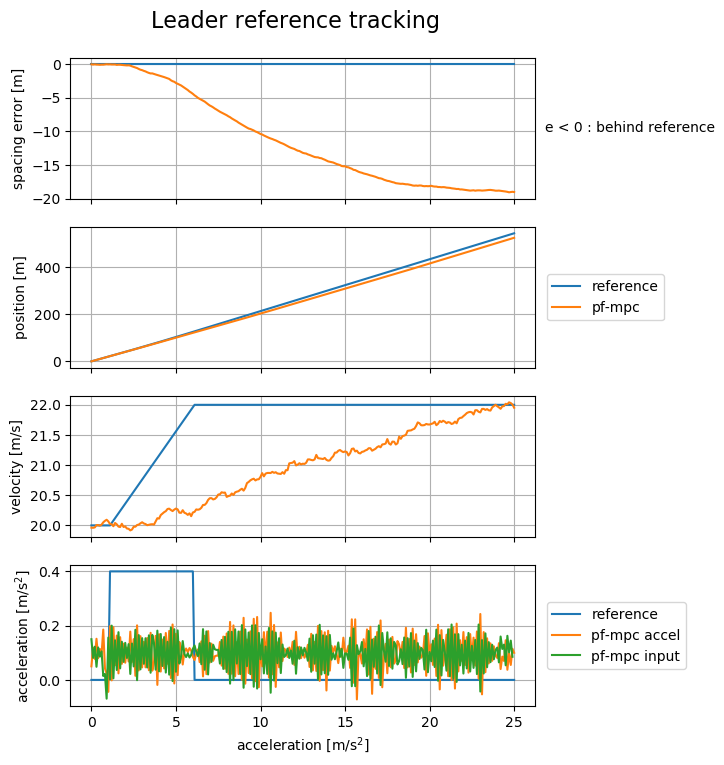

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], np.zeros(T-H), label="reference")
ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
ax[0].grid()
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', 
           transform=ax[0].transAxes)
for i in range(1, x_ref.shape[0] + 1):
    ax[i].plot(t_range_mpc, x_ref[i-1, :T-H], label="reference")
    ax[i].grid()

ax[1].plot(t_range_mpc, x_track[0, :], label="pf-mpc")
ax[2].plot(t_range_mpc, x_track[1, :], label="pf-mpc")
ax[3].plot(t_range_mpc, x_track[2, :], label="pf-mpc accel")
ax[3].plot(t_range_mpc[:-1], u_track[0, :], label="pf-mpc input")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("position [m]")
ax[2].set_ylabel("velocity [m/s]")
ax[3].set_xlabel(r"acceleration [m/s$^2$]")
ax[3].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left");
ax[3].legend(bbox_to_anchor=(1.01, 0.5), loc="center left");

## Predecessor follower platoon analysis

In [11]:
x_pfmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
x_pfmpc_hat = [np.zeros((n, T-H)) for _ in range(N + 1)]
u_pfmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_pfmpc[0] = x_ref[:, :T-H]
u_pfmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_pfmpc[0][1, 0], x_pfmpc[0][2, 0]]) + \
        rng.multivariate_normal(np.zeros(n), W)
    x_pfmpc_hat[i][:, 0] = x_pfmpc[i][:, 0] + rng.multivariate_normal(np.zeros(n), W)

# initialize assumed states, controls, and output for first timestep
x_a_pfmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
x_a_pfmpc[0] = x_pfmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_pfmpc[i][:, 0] = x_pfmpc_hat[i][:, 0]

y_a_pfmpc = [np.zeros((p, H + 1)) for _ in range(N + 1)]
y_a_pfmpc[0] = x_pfmpc[0][:2, :H+1]
for i in range(1, N + 1):
    y_a_pfmpc[i][:, 0] = dyns[i].sense(x_a_pfmpc[i][:, 0])

u_a_pfmpc = [np.zeros((m, H)) for _ in range(N + 1)]
u_a_pfmpc[0] = u_pfmpc[0][:H]

for i in range(1, N+1):
    for k in range(H):
        x_a_pfmpc[i][:, k+1] = dyns[i].forward(x_a_pfmpc[i][:, k], 
                                               u_a_pfmpc[i][:, k])
        y_a_pfmpc[i][:, k+1] = dyns[i].sense(x_a_pfmpc[i][:, k+1])

x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

In [12]:
start_time = time.time()
no_soln = False
for k in tqdm(range(T - H - 1)):
    for i in range(1, N + 1):
        x_0 = x_pfmpc_hat[i][:, k]
        y_a = y_a_pfmpc_prev[i]
        y_pred_a = y_a_pfmpc_prev[i-1]
        d = 0 if i == 1 else d_des

        z_opt, prob = pfmpc[i].control(x_0, y_a, y_pred_a, d)
        if prob.status != 'optimal':
            print(f"timestep {k}, vehicle {i}, problem returned: {prob.status}")
            no_soln = True
            break

        x_opt = np.zeros((n, H+1))
        u_opt = np.zeros((m, H))
        y_opt = np.zeros((p, H+1))

        x_opt[:, 0] = x_0
        u_opt[:, 0] = z_opt[:m]
        y_opt[:, 0] = z_opt[m:m+p]
        for t, j in enumerate(range(m+p, len(z_opt), n+m+3*p)):
            x_opt[:, t+1] = z_opt[j:j+n]
            u_opt[:, t+1] = z_opt[j+n:j+n+m]
            y_opt[:, t+1] = z_opt[j+n+m:j+n+m+p]
        x_opt[:, H] = dyns[i].forward(x_opt[:, H-1], u_opt[:, H-1])
        y_opt[:, H] = dyns[i].sense(x_opt[:, H])

        u_pfmpc[i][:, k] = u_opt[:, 0]
        x_pfmpc[i][:, k+1] = dyns[i].forward(x_0, u_opt[:, 0]) + \
            rng.multivariate_normal(np.zeros(n), W)
        y = dyns[i].C @ x_pfmpc[i][:, k] + rng.multivariate_normal(np.zeros(p), V)
        x_pfmpc_hat[i][:, k+1] = (dyns[i].Ad + L[i] @ dyns[i].C) @ x_pfmpc_hat[i][:, k] + \
            dyns[i].Bd @ u_pfmpc[i][:, k] - L[i] @ y

        # update assumed state, control, input
        u_a_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_pfmpc[i][:, H-1] = np.zeros((dyns[i].m))
        x_a_pfmpc[i][:, 0] = x_pfmpc_hat[i][:, k+1]
        y_a_pfmpc[i][:, 0] = dyns[i].sense(x_a_pfmpc[i][:, 0])
        for t in range(H):
            x_a_pfmpc[i][:, t+1] = dyns[i].forward(x_a_pfmpc[i][:, t], 
                                                   u_a_pfmpc[i][:, t])
            y_a_pfmpc[i][:, t+1] = dyns[i].sense(x_a_pfmpc[i][:, t+1])
    
    if no_soln:
        fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
        fig.suptitle(f"timestep {k}, vehicle {i} failure", size=16)
        fig.subplots_adjust(top=0.9)
        for i in range(N+1):
            ax[0].plot(t_range[:H+1], y_a_pfmpc_prev[i][0, :], 
                       label=f"{i} assumed")
            ax[1].plot(t_range[:H+1], y_a_pfmpc_prev[i][1, :], 
                       label=f"{i} assumed")
        ax[0].set_ylabel("position [m]")
        ax[0].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        ax[1].set_ylabel("velocity [m/s]")
        ax[1].set_xlabel("time [s]")
        ax[1].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        break
    
    x_a_pfmpc[0] = x_ref[:, k+1:k+H+2]
    y_a_pfmpc[0] = x_ref[:2, k+1:k+H+2]
    u_a_pfmpc[0] = x_ref[2, k+1:k+H+1]

    x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
    y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
    u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (i * (k+1))

  0%|          | 1/250 [00:00<00:25,  9.88it/s]

in class -0.03317951167615332 0.1668204883238467 0.23317951167615333
in class 0.01954695081815453 0.21954695081815453 0.1804530491818455
in class -0.010679732698160827 0.18932026730183918 0.21067973269816084
in class 0.021753497180866582 0.2217534971808666 0.17824650281913343
in class -0.0009915088810137328 0.19900849111898627 0.20099150888101375
in class -0.021831165739558053 0.17816883426044194 0.22183116573955808
in class -0.04814267321637638 0.15185732678362363 0.2481426732163764
in class 0.050160693797783575 0.2501606937977836 0.14983930620221644
in class -0.006996572980967192 0.1930034270190328 0.20699657298096721
in class -0.0514191814221462 0.14858081857785382 0.2514191814221462
in class -0.06537045629860704 0.13462954370139296 0.26537045629860706
in class 0.09795650210526319 0.2979565021052632 0.10204349789473682
in class -0.12821992445050234 0.07178007554949767 0.32821992445050235
in class 0.11367725807148821 0.3136772580714882 0.0863227419285118
in class 0.009281429914222095

  1%|          | 3/250 [00:00<00:26,  9.17it/s]

in class 0.012828224436341594 0.2128282244363416 0.1871717755636584
in class 0.10226703364096335 0.30226703364096336 0.09773296635903667
in class -0.1860383780848972 0.013961621915102806 0.3860383780848972
in class 0.08538356965777627 0.2853835696577763 0.11461643034222374
in class 0.04869227500346618 0.2486922750034662 0.15130772499653383
in class 0.004223847315913076 0.2042238473159131 0.19577615268408693
in class -0.07538788209636671 0.1246121179036333 0.2753878820963667
in class 0.03189534782109993 0.23189534782109994 0.16810465217890008
in class -0.019841092616867062 0.18015890738313295 0.21984109261686707
in class -0.03630692173587313 0.16369307826412688 0.23630692173587314
in class -0.14729854269379417 0.052701457306205846 0.3472985426937942
in class 0.09759778830293173 0.2975977883029317 0.10240221169706828
in class -0.18964682695101365 0.010353173048986364 0.38964682695101366
in class 0.11497676028128812 0.3149767602812881 0.0850232397187119
in class 0.10480099001483922 0.3048

  2%|▏         | 5/250 [00:00<00:26,  9.20it/s]

in class -0.04869231497516591 0.1513076850248341 0.24869231497516592
in class -0.03446645376992705 0.16553354623007296 0.23446645376992706
in class 0.10206640633896824 0.30206640633896825 0.09793359366103177
in class -0.14288554693467181 0.0571144530653282 0.3428855469346718
in class 0.08360374766946665 0.28360374766946667 0.11639625233053336
in class 0.09217251330378651 0.2921725133037865 0.1078274866962135
in class 0.01393648739151887 0.21393648739151888 0.18606351260848114
in class -0.050203837789715156 0.14979616221028486 0.25020383778971517
in class -0.023253026242355812 0.1767469737576442 0.22325302624235582
in class -0.06378055732531962 0.1362194426746804 0.26378055732531963
in class -0.01867979183003765 0.18132020816996236 0.21867979183003766
in class -0.031615101782333836 0.16838489821766617 0.23161510178233385
in class 0.09859461147881737 0.2985946114788174 0.10140538852118264
in class -0.0801053202882479 0.1198946797117521 0.2801053202882479
in class 0.11741904221316313 0.31

  3%|▎         | 7/250 [00:00<00:27,  8.86it/s]

in class 0.0016229854984981529 0.20162298549849816 0.19837701450150186
in class -0.07767646855499288 0.12232353144500713 0.2776764685549929
in class -0.06096136574805611 0.1390386342519439 0.2609613657480561
in class -0.05578536359850217 0.14421463640149784 0.2557853635985022
in class 0.09331772074081945 0.29331772074081947 0.10668227925918056
in class 0.07331348028200596 0.27331348028200597 0.12668651971799405
in class 0.020476892558043303 0.2204768925580433 0.1795231074419567
in class 0.0801225096108702 0.2801225096108702 0.11987749038912981
in class 0.02198577369047028 0.2219857736904703 0.17801422630952973
in class 0.09765832933889529 0.2976583293388953 0.10234167066110472
in class 0.0420747481035999 0.2420747481035999 0.1579252518964001
in class -0.028142602178898635 0.17185739782110138 0.22814260217889865
in class -0.12767292309337375 0.07232707690662626 0.32767292309337376
in class -0.02862475037614942 0.1713752496238506 0.22862475037614943
in class 0.10668227925918056 0.3066822

  4%|▎         | 9/250 [00:01<00:28,  8.49it/s]

in class 0.09198642550056335 0.29198642550056336 0.10801357449943666
in class 0.07041177725509407 0.2704117772550941 0.12958822274490595
in class 0.006912082524217045 0.20691208252421706 0.19308791747578297
in class -0.15002414114485907 0.04997585885514094 0.3500241411448591
in class -0.03230632170438863 0.16769367829561138 0.23230632170438864
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.013913232368528206 0.21391323236852822 0.1860867676314718
in class 0.14094303624564053 0.34094303624564054 0.05905696375435948
in class 0.08701072633036411 0.2870107263303641 0.1129892736696359
in class -0.013788050204374791 0.18621194979562522 0.2137880502043748
in class 0.10813799654373035 0.30813799654373036 0.09186200345626966
in class 0.09733667227503062 0.29733667227503063 0.10266332772496939
in class 0.08244815941760075 0.28244815941760076 0.11755184058239926
in class -0.13671464644406495 0.06328535355593506 0.33671464644406496
in class -0.041441371083632106 0.

  4%|▍         | 10/250 [00:01<00:28,  8.54it/s]

in class 0.11503654087679482 0.31503654087679483 0.08496345912320519
in class 0.041192121498640044 0.24119212149864006 0.15880787850135997
in class 0.11168232048891169 0.3116823204889117 0.08831767951108832
in class 0.06489788065618152 0.26489788065618153 0.1351021193438185
in class 0.08404628358327515 0.28404628358327516 0.11595371641672486
in class 0.08235121078202035 0.28235121078202036 0.11764878921797967
in class 0.1150784528252995 0.3150784528252995 0.08492154717470052
in class -0.14845628003705258 0.05154371996294743 0.3484562800370526
in class -0.035453827109528824 0.1645461728904712 0.23545382710952883
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.03303025385150074 0.23303025385150075 0.16696974614849927
in class 0.15978056446502586 0.3597805644650259 0.040219435534974146
in class 0.08561438004708166 0.2856143800470817 0.11438561995291835
in class 0.04536431768702687 0.24536431768702688 0.15463568231297314
in class 0.11920883551186834 0.319208

  5%|▍         | 12/250 [00:01<00:28,  8.33it/s]

in class -0.06878269330131337 0.13121730669868664 0.2687826933013134
in class -0.055876523120858224 0.1441234768791418 0.25587652312085823
in class 0.10668227925918056 0.30668227925918057 0.09331772074081945
in class 0.05103547275365089 0.2510354727536509 0.14896452724634912
in class 0.03937057846220926 0.23937057846220927 0.16062942153779075
in class 0.11457106633322889 0.3145710663332289 0.08542893366677112
in class 0.09603844609728718 0.2960384460972872 0.10396155390271283
in class 0.07800681731022419 0.2780068173102242 0.12199318268977583
in class 0.1143871407081063 0.3143871407081063 0.08561285929189372
in class 0.11526469917866367 0.3152646991786637 0.08473530082133635
in class -0.056837806066274865 0.14316219393372515 0.2568378060662749
in class -0.020005507504297082 0.17999449249570293 0.2200055075042971
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.008981502771989391 0.2089815027719894 0.19101849722801062
in class 0.16196642121257387 0.3619664

  6%|▌         | 14/250 [00:01<00:29,  8.01it/s]

in class 0.11940625349255884 0.31940625349255886 0.08059374650744117
in class 0.07245115198086127 0.2724511519808613 0.12754884801913874
in class 0.07168176259829595 0.27168176259829596 0.12831823740170406
in class -0.03337594872498251 0.1666240512750175 0.23337594872498252
in class -0.004779337812348405 0.1952206621876516 0.20477933781234842
in class 0.10668227925918056 0.30668227925918057 0.09331772074081945
in class 0.19154979918191267 0.3915497991819127 0.008450200818087339
in class 0.038333839829659544 0.23833383982965956 0.16166616017034047
in class 0.10853587390378916 0.30853587390378917 0.09146412609621085
in class 0.13083871844226147 0.3308387184422615 0.06916128155773854
in class 0.08548042392482191 0.2854804239248219 0.1145195760751781
in class 0.14169489708805605 0.34169489708805606 0.05830510291194396
in class 0.13303614333384006 0.3330361433338401 0.06696385666615995
in class 0.011344250711598391 0.2113442507115984 0.18865574928840162
in class -0.023297198303726674 0.1767

  6%|▌         | 15/250 [00:01<00:29,  7.98it/s]

in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.009120789073394642 0.20912078907339465 0.19087921092660537
in class 0.16032014298661046 0.36032014298661047 0.03967985701338955
in class 0.09292854275339102 0.29292854275339103 0.10707145724660899
in class 0.06818688347974722 0.26818688347974723 0.1318131165202528
in class 0.10431791673515933 0.30431791673515934 0.09568208326484068
in class 0.03960158720714224 0.23960158720714225 0.16039841279285777
in class 0.04740304655392524 0.24740304655392525 0.15259695344607477
in class 0.04105083666639153 0.24105083666639154 0.15894916333360848
in class -0.022882405670724637 0.17711759432927537 0.22288240567072465
in class 0.10668227925918056 0.30668227925918057 0.09331772074081945
in class 0.1907196775111392 0.39071967751113923 0.00928032248886082
in class 0.041013540600438714 0.24101354060043872 0.1589864593995613
in class 0.10401869691524013 0.30401869691524014 0.09598130308475988
in class 0.10036721943843552 0.30

  6%|▋         | 16/250 [00:01<00:30,  7.63it/s]

in class 0.1708699243653462 0.3708699243653462 0.029130075634653807
in class 0.15906055039506217 0.3590605503950622 0.04093944960493784
in class 0.06344051198207135 0.26344051198207136 0.13655948801792867
in class -0.011560166522722515 0.1884398334772775 0.21156016652272253
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.009702563368680361 0.20970256336868037 0.19029743663131965
in class 0.1549739715360634 0.3549739715360634 0.04502602846393661
in class 0.0958672530640603 0.2958672530640603 0.10413274693593971
in class 0.09743713465531623 0.29743713465531624 0.10256286534468378
in class 0.08864099857515462 0.28864099857515463 0.1113590014248454
in class 0.022624942668838077 0.2226249426688381 0.17737505733116193
in class 0.04621913747327433 0.24621913747327434 0.15378086252672568
in class 0.10656568991080917 0.3065656899108092 0.09343431008919084
in class 0.020780569490645995 0.220780569490646 0.17921943050935402


  7%|▋         | 18/250 [00:02<00:32,  7.11it/s]

in class 0.10668227925918057 0.30668227925918057 0.09331772074081944
in class 0.18992674890391642 0.38992674890391643 0.01007325109608359
in class 0.04885916482147612 0.24885916482147613 0.1511408351785239
in class 0.10537498298405668 0.3053749829840567 0.09462501701594334
in class 0.10432944577687686 0.3043294457768769 0.09567055422312315
in class 0.12003537878045889 0.3200353787804589 0.07996462121954112
in class 0.17702365015791388 0.3770236501579139 0.02297634984208613
in class 0.14868867995843393 0.34868867995843394 0.05131132004156608
in class 0.1034769949724299 0.3034769949724299 0.09652300502757011
in class 0.05278265458304032 0.25278265458304033 0.1472173454169597
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.011201548978875375 0.2112015489788754 0.18879845102112464
in class 0.1471845409411714 0.3471845409411714 0.05281545905882862
in class 0.09827285394681273 0.29827285394681274 0.10172714605318728
in class 0.0912294551481716 0.29122945514817

  8%|▊         | 19/250 [00:02<00:34,  6.78it/s]

in class 0.07492940332105569 0.2749294033210557 0.12507059667894432
in class 0.030249156576855007 0.23024915657685502 0.169750843423145
in class 0.05989932770496553 0.25989932770496554 0.14010067229503448
in class 0.100514720943786 0.300514720943786 0.09948527905621402
in class 0.14962738918976592 0.34962738918976594 0.050372610810234086
in class 0.10668227925918057 0.30668227925918057 0.09331772074081944
in class 0.18756011327110855 0.38756011327110856 0.012439886728891458
in class 0.05284950861683546 0.25284950861683547 0.14715049138316455
in class 0.09726684446461231 0.2972668444646123 0.1027331555353877
in class 0.11072369740565247 0.3107236974056525 0.08927630259434755
in class 0.13038209433398107 0.3303820943339811 0.06961790566601894
in class 0.16636752392938625 0.36636752392938626 0.03363247607061376


  8%|▊         | 20/250 [00:02<00:35,  6.50it/s]

in class 0.13102297111687777 0.3310229711168778 0.06897702888312224
in class 0.09734377650153991 0.2973437765015399 0.1026562234984601
in class 0.050340639442757684 0.2503406394427577 0.14965936055724233
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.013553923446706473 0.21355392344670648 0.18644607655329354
in class 0.14697387256721683 0.34697387256721685 0.05302612743278318
in class 0.10669877518829374 0.30669877518829375 0.09330122481170627
in class 0.08613806347332131 0.2861380634733213 0.1138619365266787
in class 0.06380826061261446 0.2638082606126145 0.13619173938738555
in class 0.03810020025428296 0.23810020025428297 0.16189979974571705
in class 0.06801402868678474 0.26801402868678476 0.13198597131321527
in class 0.1007181563624151 0.3007181563624151 0.09928184363758491


  9%|▉         | 22/250 [00:02<00:37,  6.09it/s]

in class 0.14336351905737477 0.3433635190573748 0.056636480942625245
in class 0.10668227925918058 0.30668227925918057 0.09331772074081943
in class 0.18584663658242967 0.3858466365824297 0.014153363417570342
in class 0.053013206746776786 0.2530132067467768 0.14698679325322322
in class 0.09067726434646595 0.29067726434646596 0.10932273565353406
in class 0.1171337969357018 0.3171337969357018 0.0828662030642982
in class 0.13043465924432507 0.3304346592443251 0.06956534075567494
in class 0.15761434753473313 0.35761434753473315 0.042385652465266876
in class 0.13087284622213824 0.33087284622213825 0.06912715377786177
in class 0.08712643525081276 0.2871264352508128 0.11287356474918725
in class 0.06446518568368065 0.26446518568368066 0.13553481431631936
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.014364503150074204 0.21436450315007421 0.1856354968499258


  9%|▉         | 23/250 [00:03<00:36,  6.17it/s]

in class 0.14623840579415714 0.34623840579415716 0.053761594205842866
in class 0.10772044390321889 0.3077204439032189 0.09227955609678112
in class 0.07951016404753086 0.2795101640475309 0.12048983595246915
in class 0.06671355225128384 0.26671355225128385 0.13328644774871617
in class 0.04612974799204972 0.24612974799204973 0.1538702520079503
in class 0.07400694714624567 0.2740069471462457 0.12599305285375434
in class 0.11062613439712532 0.31062613439712533 0.08937386560287469
in class 0.11420685913924178 0.3142068591392418 0.08579314086075823
in class 0.10668227925918058 0.30668227925918057 0.09331772074081943
in class 0.18549245251547702 0.38549245251547704 0.014507547484522987
in class 0.055501936509989136 0.25550193650998915 0.14449806349001088
in class 0.09561308149397663 0.29561308149397664 0.10438691850602339
in class 0.12399958344086248 0.3239995834408625 0.07600041655913753
in class 0.13677833454562682 0.33677833454562683 0.06322166545437319


 10%|▉         | 24/250 [00:03<00:37,  6.04it/s]

in class 0.15357698156587674 0.35357698156587675 0.046423018434123275
in class 0.13005294118348099 0.330052941183481 0.06994705881651903
in class 0.09433242414836585 0.29433242414836586 0.10566757585163417
in class 0.10597207482769688 0.3059720748276969 0.09402792517230313
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.015137204941468196 0.2151372049414682 0.18486279505853181
in class 0.1421550660219234 0.3421550660219234 0.05784493397807661
in class 0.10038645921175537 0.3003864592117554 0.09961354078824464
in class 0.07639456365876418 0.2763945636587642 0.12360543634123583
in class 0.05354422392461711 0.2535442239246171 0.1464557760753829
in class 0.04642653456234713 0.24642653456234714 0.15357346543765288


 10%|█         | 25/250 [00:03<00:39,  5.74it/s]

in class 0.06351921313282549 0.2635192131328255 0.13648078686717452
in class 0.11195147436397246 0.31195147436397247 0.08804852563602755
in class 0.09592592492528107 0.2959259249252811 0.10407407507471894
in class 0.1066822792591806 0.3066822792591806 0.09331772074081941
in class 0.18483529012070007 0.38483529012070006 0.015164709879299937
in class 0.05960530730912561 0.2596053073091256 0.1403946926908744
in class 0.10389408060391192 0.30389408060391193 0.09610591939608809
in class 0.12999328404064014 0.32999328404064016 0.07000671595935987
in class 0.15851953337526892 0.35851953337526893 0.041480466624731094
in class 0.15333284057119956 0.35333284057119957 0.04666715942880045
in class 0.14003656631833383 0.34003656631833384 0.05996343368166618


 10%|█         | 26/250 [00:03<00:41,  5.39it/s]

in class 0.08083427014937028 0.2808342701493703 0.11916572985062973
in class 0.10571362078079316 0.30571362078079317 0.09428637921920685
in class 0.09331772074081947 0.29331772074081947 0.10668227925918054
in class 0.014859770717696369 0.21485977071769638 0.18514022928230364
in class 0.14146906977860485 0.34146906977860486 0.05853093022139516
in class 0.09411599857849917 0.2941159985784992 0.10588400142150084
in class 0.06413565018923872 0.26413565018923874 0.1358643498107613
in class 0.037419913272095595 0.2374199132720956 0.16258008672790442
in class 0.04575059145734217 0.24575059145734218 0.15424940854265784
in class 0.056748994743770265 0.2567489947437703 0.14325100525622975


 11%|█         | 27/250 [00:03<00:43,  5.17it/s]

in class 0.1192388206478383 0.3192388206478383 0.0807611793521617
in class 0.09502390523623339 0.2950239052362334 0.10497609476376663
in class 0.1066822792591806 0.3066822792591806 0.09331772074081941
in class 0.18526586207800544 0.38526586207800545 0.014734137921994572
in class 0.05858811518106044 0.25858811518106045 0.14141188481893957
in class 0.10750892006209134 0.30750892006209135 0.09249107993790867
in class 0.14171325060233841 0.3417132506023384 0.0582867493976616
in class 0.16842685124380452 0.36842685124380453 0.03157314875619549
in class 0.15868398225964597 0.358683982259646 0.04131601774035404
in class 0.15574762391308905 0.35574762391308906 0.04425237608691096


 11%|█         | 28/250 [00:04<00:45,  4.93it/s]

in class 0.08537655446635073 0.28537655446635074 0.11462344553364928
in class 0.1071049966234563 0.3071049966234563 0.09289500337654372
in class 0.09331772074081948 0.2933177207408195 0.10668227925918053
in class 0.015185490464875717 0.21518549046487573 0.1848145095351243
in class 0.14181369215408834 0.34181369215408836 0.05818630784591167
in class 0.0935596890721424 0.2935596890721424 0.1064403109278576
in class 0.058740705904594126 0.25874070590459414 0.14125929409540589
in class 0.028931771256334837 0.22893177125633485 0.17106822874366517
in class 0.0431035591357567 0.2431035591357567 0.15689644086424331
in class 0.028066308815335894 0.2280663088153359 0.17193369118466412


 12%|█▏        | 29/250 [00:04<00:46,  4.76it/s]

in class 0.10681245887310942 0.30681245887310943 0.0931875411268906
in class 0.09154568494361559 0.2915456849436156 0.10845431505638442
in class 0.1066822792591806 0.3066822792591806 0.09331772074081941
in class 0.18547471163963125 0.38547471163963126 0.01452528836036876
in class 0.059460788462901926 0.25946078846290194 0.14053921153709809
in class 0.10791637784965857 0.3079163778496586 0.09208362215034144
in class 0.13446512687295864 0.33446512687295865 0.06553487312704137
in class 0.18231928721911816 0.3823192872191182 0.017680712780881847
in class 0.16231227844377782 0.36231227844377784 0.03768772155622219
in class 0.1814770064460962 0.3814770064460962 0.0185229935539038


 12%|█▏        | 30/250 [00:04<00:47,  4.64it/s]

in class 0.10446182178072583 0.30446182178072584 0.09553817821927418
in class 0.11034106668960231 0.3103410666896023 0.0896589333103977
in class 0.09331772074081948 0.2933177207408195 0.10668227925918053
in class 0.014040205782075488 0.2140402057820755 0.18595979421792452
in class 0.1391598778073715 0.3391598778073715 0.06084012219262852
in class 0.09260924118076952 0.29260924118076953 0.10739075881923049
in class 0.06886863389246711 0.2688686338924671 0.1311313661075329
in class 0.014165256318846797 0.2141652563188468 0.1858347436811532
in class 0.03920520274833361 0.23920520274833362 0.1607947972516664


 12%|█▏        | 31/250 [00:04<00:49,  4.44it/s]

in class 0.013604180022726009 0.21360418002272602 0.186395819977274
in class 0.0817194960069032 0.2817194960069032 0.11828050399309681
in class 0.09292141192926318 0.2929214119292632 0.10707858807073684
in class 0.10668227925918061 0.3066822792591806 0.0933177207408194
in class 0.18614073589156035 0.3861407358915604 0.013859264108439656
in class 0.06033648013145554 0.26033648013145555 0.13966351986854447
in class 0.10838184168135045 0.30838184168135047 0.09161815831864956
in class 0.12796153599234983 0.32796153599234984 0.07203846400765018
in class 0.1841700846614449 0.3841700846614449 0.0158299153385551


 13%|█▎        | 32/250 [00:04<00:48,  4.51it/s]

in class 0.1651200086685911 0.3651200086685911 0.0348799913314089
in class 0.18958210827463118 0.3895821082746312 0.010417891725368833
in class 0.12517907417201934 0.32517907417201936 0.07482092582798067
in class 0.0918291748270641 0.2918291748270641 0.10817082517293591
in class 0.09331772074081948 0.2933177207408195 0.10668227925918053
in class 0.013177568913760207 0.21317756891376022 0.1868224310862398
in class 0.14036645791795055 0.34036645791795056 0.05963354208204946
in class 0.09058511891612109 0.2905851189161211 0.10941488108387892
in class 0.07990884926063613 0.27990884926063614 0.12009115073936388
in class 0.01669057249673811 0.21669057249673812 0.1833094275032619
in class 0.033210693030651495 0.2332106930306515 0.16678930696934852


 13%|█▎        | 33/250 [00:05<00:47,  4.54it/s]

in class 0.016142573261209048 0.21614257326120906 0.18385742673879096
in class 0.08405012571687998 0.28405012571688 0.11594987428312004
in class 0.11689989440044624 0.31689989440044625 0.08310010559955378
in class 0.10668227925918061 0.3066822792591806 0.0933177207408194
in class 0.18683663440918036 0.38683663440918037 0.013163365590819653
in class 0.05927510992911722 0.25927510992911723 0.1407248900708828
in class 0.10897498807122297 0.308974988071223 0.09102501192877704
in class 0.11588958063959409 0.3158895806395941 0.08411041936040592
in class 0.18319206403882693 0.38319206403882694 0.01680793596117308
in class 0.1711368790579164 0.3711368790579164 0.028863120942083598


 14%|█▎        | 34/250 [00:05<00:47,  4.58it/s]

in class 0.17987071362558815 0.37987071362558816 0.02012928637441186
in class 0.10824517909879328 0.3082451790987933 0.09175482090120674
in class 0.07865669083981253 0.27865669083981254 0.12134330916018748
in class 0.0933177207408195 0.2933177207408195 0.10668227925918052
in class 0.013050406863563152 0.21305040686356316 0.18694959313643686
in class 0.14286354875086238 0.3428635487508624 0.05713645124913763
in class 0.09031495123587518 0.2903149512358752 0.10968504876412483
in class 0.08535786989818428 0.2853578698981843 0.11464213010181573
in class 0.01999522232990225 0.21999522232990226 0.18000477767009776


 14%|█▍        | 35/250 [00:05<00:49,  4.37it/s]

in class 0.028764306849966115 0.22876430684996613 0.1712356931500339
in class 0.011373401995213861 0.21137340199521387 0.18862659800478615
in class 0.09971841218509114 0.29971841218509115 0.10028158781490887
in class 0.10488865818849957 0.3048886581884996 0.09511134181150044
in class 0.10668227925918071 0.30668227925918073 0.0933177207408193
in class 0.18689247352195631 0.3868924735219563 0.013107526478043696
in class 0.055472398005124934 0.25547239800512495 0.14452760199487508
in class 0.10904675029954469 0.3090467502995447 0.09095324970045532
in class 0.11545934072787079 0.3154593407278708 0.08454065927212923


 14%|█▍        | 36/250 [00:05<00:48,  4.38it/s]

in class 0.1728236117404185 0.3728236117404185 0.02717638825958152
in class 0.1826237871059675 0.3826237871059675 0.017376212894032517
in class 0.1860004708715186 0.3860004708715186 0.013999529128481403
in class 0.09166502825782841 0.2916650282578284 0.1083349717421716
in class 0.10897439922362695 0.30897439922362696 0.09102560077637306
in class 0.09331772074081951 0.2933177207408195 0.1066822792591805
in class 0.012685951442659132 0.21268595144265914 0.18731404855734088
in class 0.14559901468848035 0.34559901468848037 0.054400985311519656
in class 0.08868583125994545 0.28868583125994546 0.11131416874005456


 15%|█▍        | 37/250 [00:06<00:49,  4.30it/s]

in class 0.08331305821927448 0.2833130582192745 0.11668694178072553
in class 0.03781678295397528 0.2378167829539753 0.16218321704602473
in class 0.01689055539006512 0.21689055539006513 0.1831094446099349
in class 0.017004364630085256 0.21700436463008527 0.18299563536991476
in class 0.11780591550412778 0.3178059155041278 0.08219408449587223
in class 0.09533400260968516 0.2953340026096852 0.10466599739031485
in class 0.10668227925918072 0.30668227925918073 0.09331772074081929
in class 0.18734829917854365 0.38734829917854363 0.012651700821456363
in class 0.05416032384768543 0.25416032384768544 0.14583967615231458
in class 0.11528382491439304 0.31528382491439305 0.08471617508560697
in class 0.11725815354188929 0.3172581535418893 0.08274184645811072
in class 0.15690213865009794 0.35690213865009796 0.04309786134990207
in class 0.1781679244746459 0.3781679244746459 0.0218320755253541
in class 0.18204053875988535 0.38204053875988536 0.01795946124011466
in class 0.07785332994269245 0.2778533299

 15%|█▌        | 38/250 [00:06<00:49,  4.28it/s]

in class 0.09331772074081952 0.2933177207408195 0.10668227925918049
in class 0.013096637908999231 0.21309663790899924 0.18690336209100078
in class 0.14815838131974768 0.3481583813197477 0.05184161868025233
in class 0.08479938829705924 0.28479938829705925 0.11520061170294077
in class 0.08318819856445758 0.2831881985644576 0.11681180143554243
in class 0.047344094122368396 0.2473440941223684 0.15265590587763161
in class 0.018108608243719626 0.21810860824371964 0.18189139175628039
in class 0.01120498587237817 0.21120498587237818 0.18879501412762184
in class 0.14047536762634527 0.3404753676263453 0.05952463237365474
in class 0.07500545476144627 0.2750054547614463 0.12499454523855374


 16%|█▌        | 39/250 [00:06<00:47,  4.40it/s]

in class 0.10668227925918074 0.30668227925918073 0.09331772074081927
in class 0.186518680362603 0.386518680362603 0.013481319637397016
in class 0.049726170047908136 0.24972617004790815 0.15027382995209188
in class 0.11502828055371483 0.31502828055371485 0.08497171944628518
in class 0.11831304348818272 0.31831304348818273 0.08168695651181729
in class 0.14784056522741262 0.34784056522741263 0.05215943477258739
in class 0.17761164859065337 0.3776116485906534 0.02238835140934664
in class 0.18670969345905775 0.38670969345905776 0.013290306540942265
in class 0.05235170929245703 0.25235170929245704 0.14764829070754298
in class 0.13292718557190586 0.33292718557190587 0.06707281442809415


 16%|█▌        | 40/250 [00:06<00:46,  4.51it/s]

in class 0.09331772074081975 0.29331772074081974 0.10668227925918027
in class 0.012920113862027571 0.21292011386202758 0.18707988613797244
in class 0.15148018210363468 0.3514801821036347 0.048519817896365336
in class 0.08658208488472718 0.2865820848847272 0.11341791511527283
in class 0.08802354045996341 0.2880235404599634 0.1119764595400366
in class 0.05697333599201482 0.25697333599201483 0.1430266640079852
in class 0.01999250853420298 0.219992508534203 0.18000749146579703
in class 0.021321565067073944 0.22132156506707396 0.17867843493292607
in class 0.1528737842056236 0.3528737842056236 0.047126215794376425
in class 0.060555767350441325 0.26055576735044134 0.13944423264955869


 16%|█▋        | 41/250 [00:07<00:46,  4.48it/s]

in class 0.10668227925918077 0.3066822792591808 0.09331772074081925
in class 0.18695450535963304 0.38695450535963305 0.013045494640366972
in class 0.048104876485742354 0.24810487648574236 0.15189512351425766
in class 0.1105640775324892 0.3105640775324892 0.08943592246751081
in class 0.1105646551054138 0.3105646551054138 0.08943534489458621
in class 0.13825824827354416 0.33825824827354417 0.06174175172645585
in class 0.1786873059195382 0.3786873059195382 0.021312694080461825
in class 0.17044355993155458 0.3704435599315546 0.029556440068445433
in class 0.042063125233062326 0.24206312523306234 0.15793687476693768


 17%|█▋        | 42/250 [00:07<00:47,  4.34it/s]

in class 0.16120602989006372 0.36120602989006373 0.03879397010993629
in class 0.09331772074081979 0.2933177207408198 0.10668227925918022
in class 0.013137268083901699 0.2131372680839017 0.1868627319160983
in class 0.15254455208312612 0.35254455208312613 0.047455447916873894
in class 0.08964769892142233 0.28964769892142234 0.11035230107857769
in class 0.09222483619239652 0.29222483619239653 0.10777516380760349
in class 0.05939421789819255 0.25939421789819256 0.14060578210180746
in class 0.024136963127197486 0.2241369631271975 0.17586303687280253
in class 0.02567897245068096 0.22567897245068097 0.17432102754931905
in class 0.1592360519979592 0.3592360519979592 0.040763948002040806


 17%|█▋        | 43/250 [00:07<00:47,  4.33it/s]

in class 0.01778888944698087 0.21778888944698088 0.18221111055301914
in class 0.10668227925918079 0.3066822792591808 0.09331772074081922
in class 0.18666609518223848 0.3866660951822385 0.013333904817761533
in class 0.04676702191876014 0.24676702191876015 0.15323297808123987
in class 0.10943427437740172 0.30943427437740173 0.09056572562259829
in class 0.10686713442101059 0.3068671344210106 0.09313286557898942
in class 0.14281239685732072 0.34281239685732073 0.05718760314267929
in class 0.17649951137037778 0.3764995113703778 0.02350048862962223
in class 0.1713125010095502 0.3713125010095502 0.02868749899044981


 18%|█▊        | 44/250 [00:07<00:49,  4.20it/s]

in class 0.036652404089542845 0.23665240408954286 0.16334759591045717
in class 0.19227238027530769 0.3922723802753077 0.007727619724692325
in class 0.09331772074081982 0.29331772074081985 0.1066822792591802
in class 0.0130134593371658 0.2130134593371658 0.1869865406628342
in class 0.15457478058007568 0.3545747805800757 0.045425219419924334
in class 0.08939306656012258 0.2893930665601226 0.11060693343987743
in class 0.09215465961825364 0.29215465961825365 0.10784534038174637
in class 0.053911939230251615 0.2539119392302516 0.1460880607697484


 18%|█▊        | 45/250 [00:08<00:50,  4.05it/s]

in class 0.031826393963250155 0.23182639396325017 0.16817360603674986
in class 0.03486933544629389 0.2348693354462939 0.16513066455370612
in class 0.15642381604630096 0.35642381604630097 0.043576183953699055
in class -0.0006895700692766127 0.1993104299307234 0.20068957006927662
in class 0.1066822792591813 0.30668227925918135 0.0933177207408187
in class 0.18631960375526876 0.38631960375526875 0.013680396244731247
in class 0.04430696633205522 0.24430696633205523 0.1556930336679448
in class 0.1131051518234647 0.3131051518234647 0.08689484817653531
in class 0.10620801391089119 0.3062080139108912 0.09379198608910883


 18%|█▊        | 46/250 [00:08<00:50,  4.05it/s]

in class 0.14879886721260105 0.34879886721260106 0.05120113278739896
in class 0.1647013336624612 0.3647013336624612 0.03529866633753881
in class 0.16678765080886748 0.3667876508088675 0.03321234919113253
in class 0.04131014262293231 0.24131014262293232 0.1586898573770677
in class 0.2234041690585018 0.4234041690585018 -0.02340416905850179
in class 0.09331772074081988 0.2933177207408199 0.10668227925918013
in class 0.013685880063806333 0.21368588006380634 0.18631411993619368
in class 0.15683308335034196 0.356833083350342 0.04316691664965805


 19%|█▉        | 47/250 [00:08<00:50,  4.04it/s]

in class 0.08714702332940938 0.2871470233294094 0.11285297667059063
in class 0.09848176152815458 0.2984817615281546 0.10151823847184543
in class 0.05623575661505509 0.2562357566150551 0.14376424338494492
in class 0.04037191962322595 0.24037191962322596 0.15962808037677406
in class 0.025151665482823216 0.22515166548282323 0.1748483345171768
in class 0.16556699830743993 0.36556699830743994 0.034433001692560083
in class -0.045262353270413946 0.15473764672958606 0.24526235327041396
in class 0.10668227925918138 0.3066822792591814 0.09331772074081864
in class 0.18704424898638083 0.38704424898638085 0.012955751013619177
in class 0.04280379473042195 0.24280379473042196 0.15719620526957806
in class 0.11129670601624464 0.31129670601624465 0.08870329398375537
in class 0.10077544177018316 0.30077544177018317 0.09922455822981685
in class 0.14313460462899918 0.3431346046289992 0.056865395371000826
in class 0.14709750352695794 0.34709750352695795 0.05290249647304207
in class 0.19185270133543497 0.391

 19%|█▉        | 48/250 [00:08<00:50,  3.99it/s]

in class 0.17053702882096688 0.3705370288209669 0.029462971179033126
in class 0.09331772074081995 0.29331772074081996 0.10668227925918006
in class 0.013335803557154746 0.21333580355715476 0.18666419644284526
in class 0.1576272649551712 0.3576272649551712 0.0423727350448288
in class 0.09291166051839217 0.2929116605183922 0.10708833948160784
in class 0.09377431435027672 0.29377431435027673 0.10622568564972329
in class 0.05982930776977735 0.25982930776977736 0.14017069223022266
in class 0.06353289354961156 0.26353289354961157 0.13646710645038845
in class 0.007540547022807154 0.20754054702280716 0.19245945297719286


 20%|█▉        | 49/250 [00:09<00:50,  3.94it/s]

in class 0.15463461644801413 0.35463461644801414 0.04536538355198588
in class 0.015814742400059867 0.21581474240005988 0.18418525759994014
in class 0.1066822792591824 0.3066822792591824 0.09331772074081761
in class 0.18666029811318563 0.38666029811318564 0.013339701886814381
in class 0.04191052868139955 0.24191052868139956 0.15808947131860046
in class 0.10398890348935597 0.303988903489356 0.09601109651064405
in class 0.11377902090677883 0.31377902090677884 0.08622097909322118
in class 0.1360757459086699 0.3360757459086699 0.06392425409133012
in class 0.12535642308943684 0.32535642308943685 0.07464357691056317
in class 0.19684815944204015 0.39684815944204016 0.003151840557959862


 20%|██        | 50/250 [00:09<00:50,  3.96it/s]

in class 0.04402811363309578 0.2440281136330958 0.15597188636690423
in class 0.19784462224839983 0.39784462224839984 0.002155377751600185
in class 0.09331772074082006 0.2933177207408201 0.10668227925917995
in class 0.014084932572512004 0.21408493257251202 0.185915067427488
in class 0.15793078260432858 0.3579307826043286 0.04206921739567143
in class 0.09868908330059845 0.29868908330059846 0.10131091669940157
in class 0.0778215485653524 0.2778215485653524 0.12217845143464762
in class 0.07243076603225518 0.2724307660322552 0.12756923396774483
in class 0.0807651220365928 0.2807651220365928 0.1192348779634072


 20%|██        | 51/250 [00:09<00:51,  3.86it/s]

in class 0.007634197654315944 0.20763419765431596 0.19236580234568407
in class 0.15690289373063226 0.3569028937306323 0.043097106269367746
in class -0.0053702927947334445 0.19462970720526657 0.20537029279473346
in class 0.10668227925918253 0.30668227925918257 0.09331772074081748
in class 0.1847518987745202 0.3847518987745202 0.015248101225479815
in class 0.040083329767553244 0.24008332976755326 0.15991667023244677
in class 0.0995268719322544 0.2995268719322544 0.10047312806774561
in class 0.1307922281242544 0.3307922281242544 0.06920777187574562


 21%|██        | 52/250 [00:09<00:50,  3.93it/s]

in class 0.12033558697246782 0.32033558697246783 0.07966441302753219
in class 0.1256538249414798 0.3256538249414798 0.0743461750585202
in class 0.18605962999725234 0.38605962999725235 0.01394037000274767
in class 0.04799272285354439 0.2479927228535444 0.15200727714645562
in class 0.21155112179858326 0.4115511217985833 -0.011551121798583253
in class 0.0933177207408203 0.2933177207408203 0.10668227925917971
in class 0.01582595168114609 0.2158259516811461 0.18417404831885392
in class 0.16232440934957781 0.3623244093495778 0.0376755906504222
in class 0.10098383939378208 0.3009838393937821 0.09901616060621793
in class 0.06752206802498684 0.26752206802498685 0.13247793197501317
in class 0.08199017020757626 0.2819901702075763 0.11800982979242375
in class 0.07723803540113394 0.27723803540113395 0.12276196459886607
in class 0.017427065423982757 0.21742706542398277 0.18257293457601725
in class 0.16008941866471904 0.36008941866471905 0.03991058133528097
in class -0.025494403443613756 0.1745055965

 21%|██        | 53/250 [00:10<00:52,  3.78it/s]

in class 0.10668227925918444 0.30668227925918445 0.09331772074081557
in class 0.18320886706698342 0.3832088670669834 0.016791132933016595
in class 0.034640612683276784 0.2346406126832768 0.16535938731672323
in class 0.09861929850516393 0.29861929850516394 0.10138070149483608
in class 0.13243276551958139 0.3324327655195814 0.06756723448041863
in class 0.12047070026463835 0.32047070026463836 0.07952929973536166
in class 0.11629626623210676 0.31629626623210677 0.08370373376789325
in class 0.18362775588948832 0.38362775588948833 0.01637224411051169


 22%|██▏       | 54/250 [00:10<00:52,  3.71it/s]

in class 0.040685089042268086 0.2406850890422681 0.15931491095773193
in class 0.17027471085578272 0.37027471085578273 0.029725289144217293
in class 0.0933177207408206 0.29331772074082063 0.1066822792591794
in class 0.0180262344560487 0.2180262344560487 0.1819737655439513
in class 0.1684762836985202 0.3684762836985202 0.03152371630147982
in class 0.09989916030341695 0.29989916030341696 0.10010083969658307
in class 0.06515303056609523 0.26515303056609524 0.13484696943390478
in class 0.06797031084935101 0.267970310849351 0.132029689150649
in class 0.07757613423278986 0.2775761342327899 0.12242386576721015


 22%|██▏       | 55/250 [00:10<00:51,  3.77it/s]

in class 0.011631027401486804 0.21163102740148682 0.1883689725985132
in class 0.15844744859099436 0.35844744859099437 0.041552551409005656
in class 0.025035914878998256 0.22503591487899827 0.17496408512100176
in class 0.10668227925918475 0.3066822792591848 0.09331772074081526
in class 0.18207697767864045 0.38207697767864046 0.01792302232135956
in class 0.032090986251245845 0.23209098625124586 0.16790901374875417
in class 0.10243906023163718 0.3024390602316372 0.09756093976836283
in class 0.1377988279772624 0.3377988279772624 0.062201172022737616
in class 0.1443291973237728 0.3443291973237728 0.055670802676227205


 22%|██▏       | 56/250 [00:10<00:50,  3.82it/s]

in class 0.1349090403168729 0.3349090403168729 0.06509095968312711
in class 0.19271799356995567 0.3927179935699557 0.007282006430044341
in class 0.03555084870280334 0.23555084870280335 0.16444915129719667
in class 0.18032715464749982 0.38032715464749983 0.01967284535250019
in class 0.09331772074082079 0.2933177207408208 0.10668227925917922
in class 0.01744078915005573 0.21744078915005574 0.18255921084994428
in class 0.16799552479382618 0.3679955247938262 0.03200447520617383
in class 0.09342110807784954 0.29342110807784955 0.10657889192215048
in class 0.06182881811971397 0.261828818119714 0.13817118188028604
in class 0.054636955016158506 0.2546369550161585 0.1453630449838415
in class 0.05540100415656202 0.25540100415656203 0.144598995843438
in class -0.0003029200087927286 0.19969707999120728 0.20030292000879274
in class 0.15885401453019865 0.35885401453019866 0.04114598546980136
in class -0.00030426172839348453 0.19969573827160653 0.2003042617283935


 23%|██▎       | 57/250 [00:11<00:52,  3.69it/s]

in class 0.10668227925918507 0.30668227925918506 0.09331772074081494
in class 0.1825134329285076 0.3825134329285076 0.017486567071492404
in class 0.02920973729547005 0.22920973729547006 0.17079026270452996
in class 0.11285289367130913 0.31285289367130914 0.08714710632869088
in class 0.13763496628856808 0.3376349662885681 0.06236503371143193
in class 0.14674667063173263 0.34674667063173265 0.05325332936826738
in class 0.150983951082583 0.350983951082583 0.04901604891741701
in class 0.20864488015133054 0.40864488015133055 -0.008644880151330525
in class 0.047661549615559906 0.24766154961555992 0.1523384503844401
in class 0.22503285906040915 0.42503285906040916 -0.02503285906040914


 23%|██▎       | 58/250 [00:11<01:02,  3.06it/s]

in class 0.09331772074082088 0.2933177207408209 0.10668227925917913
in class 0.01774454226835029 0.2177445422683503 0.18225545773164972
in class 0.17136617753486816 0.37136617753486817 0.028633822465131853
in class 0.0836784652622804 0.2836784652622804 0.11632153473771961
in class 0.06981361688880572 0.26981361688880573 0.1301863831111943
in class 0.057894918091807135 0.25789491809180715 0.14210508190819288
in class 0.04081046416040657 0.24081046416040658 0.15918953583959344
in class -0.020652108388552026 0.17934789161144798 0.22065210838855204


 24%|██▎       | 59/250 [00:11<01:04,  2.96it/s]

in class 0.15051662197873084 0.35051662197873085 0.049483378021269175
in class -0.046067893146572114 0.1539321068534279 0.24606789314657213
in class 0.10668227925918539 0.3066822792591854 0.09331772074081462
in class 0.18025242677814818 0.3802524267781482 0.019747573221851833
in class 0.02650787155892631 0.22650787155892632 0.1734921284410737
in class 0.12460403350115623 0.32460403350115624 0.07539596649884378
in class 0.12951015029490143 0.32951015029490144 0.07048984970509858


 24%|██▍       | 60/250 [00:12<01:00,  3.13it/s]

in class 0.13825985476285796 0.33825985476285797 0.06174014523714205
in class 0.16399867613549368 0.3639986761354937 0.03600132386450633
in class 0.18316250694660807 0.3831625069466081 0.01683749305339194
in class 0.06098396045014853 0.26098396045014854 0.13901603954985148
in class 0.1745370076100614 0.3745370076100614 0.0254629923899386
in class 0.09331772074082477 0.2933177207408248 0.10668227925917524
in class 0.02045456383343644 0.22045456383343645 0.17954543616656357
in class 0.17468428272400427 0.3746842827240043 0.02531571727599574
in class 0.0712404680690224 0.2712404680690224 0.1287595319309776
in class 0.07257998086459372 0.27257998086459373 0.1274200191354063
in class 0.06197699215705432 0.26197699215705433 0.1380230078429457
in class 0.03797634765824087 0.23797634765824088 0.16202365234175914
in class 0.013000596808452336 0.21300059680845235 0.18699940319154768
in class 0.11852979042445977 0.3185297904244598 0.08147020957554024


 24%|██▍       | 61/250 [00:12<00:57,  3.29it/s]

In [ ]:
print(f"\npf-mpc average rate: {1 / avg_time} Hz")


pf-mpc average rate: 22.49374783220419 Hz


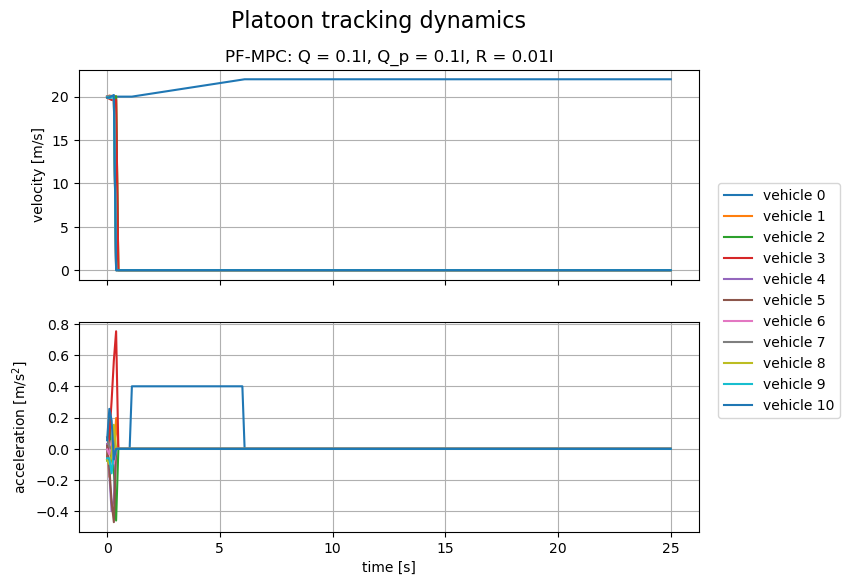

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(f"PF-MPC: Q = {q_vals[2]}I, Q_p = {q_p_vals[2]}I, R = {r_vals[2]}I")
fig.subplots_adjust(top=0.88)

ax[0].plot(t_range_mpc, x_pfmpc[0][1, :], label=f"vehicle 0")
ax[1].plot(t_range_mpc, x_pfmpc[0][2, :], label=f"vehicle 0")
for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0].plot(t_range_mpc, x_pfmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_pfmpc[i][2, :], label=f"vehicle {i}")

ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")

In [ ]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[0][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[0][1, :]

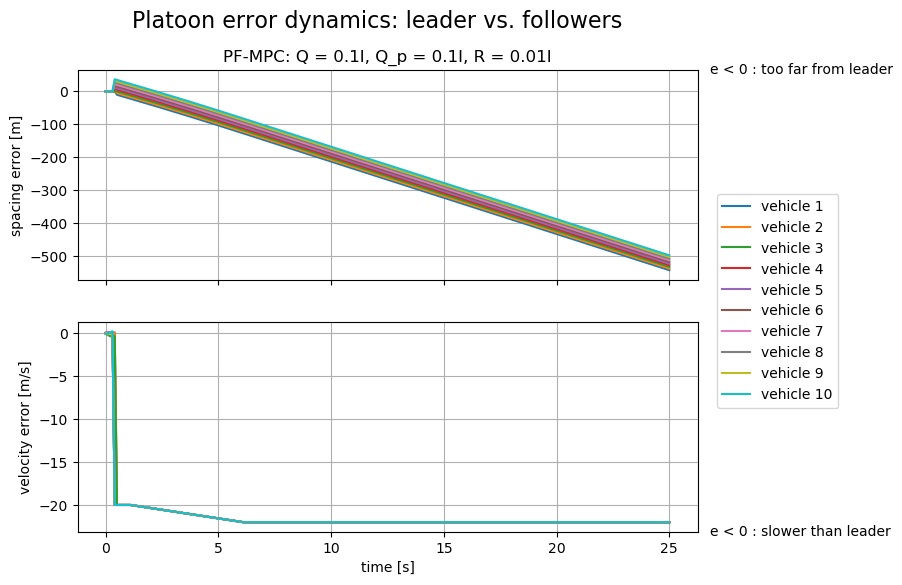

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(f"PF-MPC: Q = {q_vals[2]}I, Q_p = {q_p_vals[2]}I, R = {r_vals[2]}I")
fig.subplots_adjust(top=0.88)

for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")

In [ ]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[i-1][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[i-1][1, :]

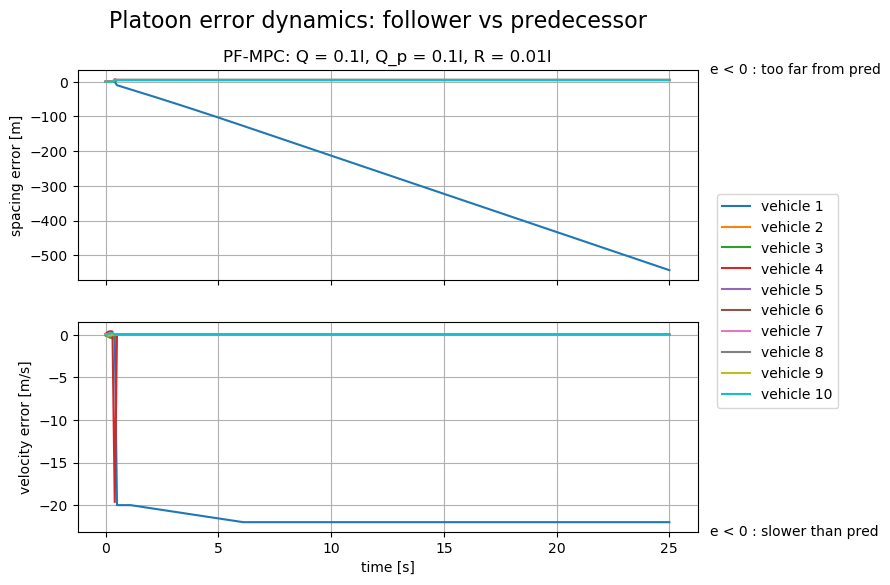

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(f"PF-MPC: Q = {q_vals[2]}I, Q_p = {q_p_vals[2]}I, R = {r_vals[2]}I")
fig.subplots_adjust(top=0.88)

for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")